- load model #16
- explainer = shap.KernelExplainer(model, X_train)
- get shap_values = explainer.shap_values(X_test_shap)
- save shap_values_16_n_samples.npy\
=> shap values for 212 features! 128 svd components + 84 handselected genes
- same steps for model #17

In [1]:
%%capture output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install tables
# necessary for pd.read_hdf()
!pip install shap

!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress
# !pip install catboost
!pip install shap
!pip install anndata

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import shap

import anndata as ad

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

## data load

In [4]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'
private_data_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data'

raw_path =  lrz_path + 'input/raw/'  # '../../../input/raw/'

cite_target_path = lrz_path + 'input/target/cite/'   # '../../../input/target/cite/'
cite_feature_path = lrz_path + 'input/features/cite/'   # '../../../input/features/cite/'
cite_mlp_path = lrz_path + 'model/cite/mlp/'   # '../../../model/cite/mlp/'   # '../../../model/cite/mlp/'
cite_cb_path = lrz_path + 'model/cite/cb/'   # '../../../model/cite/cb/'

# multi_target_path = lrz_path + 'input/target/multi/'   # '../../../input/target/multi/'
# multi_feature_path = lrz_path + 'input/features/multi/'   # '../../../input/features/multi/'
# multi_mlp_path = lrz_path + 'model/multi/mlp/'   # '../../../model/multi/mlp/'
# multi_cb_path = lrz_path + 'model/multi/cb/'   # '../../../model/multi/cb/'

index_path = lrz_path + 'input/preprocess/cite/'

output_path = lrz_path + 'output/'   # '../../../output/'

## Cite  (code from codebase, same steps as in run_model.ipynb)

In [5]:
# short names of models used in ensemble
mlp_model_name = [
    'corr_add_con_imp',
    'corr_last_v3', 
    'corr_c_add_w2v_v1_mish_flg',
    'corr_c_add_w2v_v1_flg',
    'corr_c_add_84_v1',
    'corr_c_add_120_v1',
    'corr_w2v_cell_flg',
    'corr_best_cell_120',
    'corr_cluster_cell',
    'corr_w2v_128',
    'corr_imp_w2v_128',
    'corr_snorm',
    'corr_best_128',
    'corr_best_64',
    'corr_cluster_128',
    'corr_cluster_64',
    'corr_svd_128',
    'corr_svd_64',
             ]

In [6]:
# create model_name_list containing the actual file name of each model from mlp_model_name
model_name_list = []

for i in mlp_model_name:
    for num, j in enumerate(os.listdir(cite_mlp_path)):
        if i in j:
            model_name_list.append(j)

len(model_name_list)
model_name_list

['cite_mlp_corr_add_con_imp_flg_donor_val_50',
 'cite_mlp_corr_last_v3_flg_donor_val_55',
 'cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66',
 'cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66',
 'cite_mlp_corr_c_add_84_v1_flg_donor_val_47',
 'cite_mlp_corr_c_add_120_v1_flg_donor_val_63',
 'cite_mlp_corr_w2v_cell_flg_donor_val_51',
 'cite_mlp_corr_best_cell_120_flg_donor_val_51',
 'cite_mlp_corr_cluster_cell_flg_donor_val_64',
 'cite_mlp_corr_w2v_128_flg_donor_val_42',
 'cite_mlp_corr_imp_w2v_128_flg_donor_val_38',
 'cite_mlp_corr_snorm_flg_donor_val_39',
 'cite_mlp_corr_best_128_flg_donor_val_45',
 'cite_mlp_corr_best_64_flg_donor_val_50',
 'cite_mlp_corr_cluster_128_flg_donor_val_51',
 'cite_mlp_corr_cluster_64_flg_donor_val_57',
 'cite_mlp_corr_svd_128_flg_donor_val_30',
 'cite_mlp_corr_svd_64_flg_donor_val_38']

In [7]:
# list of file names: test sets that correspond to each model in model_name_list
# weights used for weighting model predictions in ensemble
weight = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]
weight_sum = np.array(weight).sum()
weight_sum

# create dict of shape {model_name: [test set, weight]}
model_feat_dict = {model_name_list[0]:['X_test_add_con_imp.pickle', 1],
                   model_name_list[1]:['X_test_last_v3.pickle', 0.3],
                   model_name_list[2]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[3]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[4]:['X_test_c_add_84_v1.pickle', 1],
                   model_name_list[5]:['X_test_c_add_v1.pickle', 1],
                   
                   model_name_list[6]:['X_test_feature_w2v_cell.pickle', 1],
                   model_name_list[7]:['X_test_best_cell_128_120.pickle', 1],
                   model_name_list[8]:['X_test_cluster_cell_128.pickle', 1],
                   
                   model_name_list[9]:['X_test_feature_w2v.pickle', 0.8],
                   model_name_list[10]:['X_test_feature_imp_w2v.pickle',0.8],
                   model_name_list[11]:['X_test_feature_snorm.pickle', 0.8],
                   model_name_list[12]:['X_test_best_128.pickle', 0.8],
                   model_name_list[13]:['X_test_best_64.pickle', 0.5],
                   model_name_list[14]:['X_test_cluster_128.pickle', 0.5],
                   model_name_list[15]:['X_test_cluster_64.pickle', 0.5],
                   model_name_list[16]:['X_test_svd_128.pickle', 1],
                   model_name_list[17]:['X_test_svd_64.pickle', 1],
                   
                   'best_128':['X_test_best_128.pickle', 2],
                   'best_64':['X_test_best_64.pickle', 2],
                  }

### cite model (from codebase)

Only need to load the model, not run the predictions as they are in run_model.ipynb

In [8]:
def std(x):
    x = np.array(x)
    return (x - x.mean(1).reshape(-1, 1)) / x.std(1).reshape(-1, 1)

In [9]:
class CiteDataset_test(Dataset):
    
    def __init__(self, feature):
        self.feature = feature
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index]
        }
        return d

In [10]:
class CiteModel(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.ReLU(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.ReLU(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.ReLU(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
        
        from_numpy = False
        
      ##
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            from_numpy = True
        X = X.to(device)  # Move the input to the appropriate device if necessary
        ##
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        if from_numpy:
            out = out.cpu().detach().numpy()
            
        return out

In [11]:
class CiteModel_mish(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel_mish, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.Mish(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.Mish(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.Mish(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
    
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        return out

In [12]:
def test_loop(model, loader):
    
    model.eval()
    predicts=[]

    for d in tqdm(loader):
        with torch.no_grad():
            X = d['X'].to(device)
            logits = model(X)
            predicts.append(logits.detach().cpu().numpy())
            
    return np.concatenate(predicts)

### model #16

In [13]:
# only need model, not whole prediction

# model #16: cite_mlp_corr_svd_128_flg_donor_val_30

model_name = 'cite_mlp_corr_svd_128_flg_donor_val_30'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model16 = CiteModel_mish(feature_dims)
else:
    model16 = CiteModel(feature_dims)
    
model16 = model16.to(device)
model16.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

<All keys matched successfully>

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [14]:
# X_train for model #16: 'X_svd_128.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_128.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

# explainer16 = shap.KernelExplainer(model16, shap.sample(X_train, 1000))

med = X_train.median().values.reshape((1,X_train.shape[1]))
# explainer16 = shap.KernelExplainer(model16, med)

# zeros = np.zeros((1,212), dtype=float)
explainer16 = shap.KernelExplainer(model16, med)

X_train:  (70988, 212)
X_test:  (48203, 212)


In [15]:
X_test_shap = ad.read_h5ad('X_test_shap_16_50_samples.h5ad')

In [16]:
np.set_printoptions(suppress=True)
med[:,:15].round(2)

array([[87.35, -2.75, -2.78, -0.3 , -0.38, -0.92, -0.12, -0.59,  0.13,
        -0.51,  0.2 ,  0.12, -0.13, -0.13,  0.06]], dtype=float32)

In [17]:
# features: genes and svd -> omnipath: genes
# model: mostly relying on genes or svd? -> later

In [18]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer16.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_16_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [19]:
# shap_values[0]

### model #17

In [20]:
# only need model, not whole prediction
# model #17: cite_mlp_corr_svd_64_flg_donor_val_38

model_name = 'cite_mlp_corr_svd_64_flg_donor_val_38'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model17 = CiteModel_mish(feature_dims)
else:
    model17 = CiteModel(feature_dims)
    
model17 = model17.to(device)
model17.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

<All keys matched successfully>

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [21]:
# X_train for model #17: 'X_svd_64.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_64.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer17 = shap.KernelExplainer(model17, med)  #shap.sample(X_train, 1000))

X_train:  (70988, 148)
X_test:  (48203, 148)


In [22]:
X_test_shap = ad.read_h5ad('X_test_shap_17_50_samples.h5ad')

In [23]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer17.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_17_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [24]:
# shap_values[0]

### same steps for private test data

steps for model 16: compute shap values on 50 samples per cell type

In [25]:
X_train_p_sampled = ad.read_h5ad('private_train_input_max_samples.h5ad')  # 160 samples per cell type -> even distr.
X_train_p_sampled.obs

,kaggle_dataset,day,donor,cell_type,ID
"TACAGGTAGCAGGGAG-1-('31800', 2)",train,2,31800,BP,46924
"TTTCGATGTACCTATG-1-('31800', 2)",train,2,31800,BP,47398
"AACGGGAGTTGACTAC-1-('31800', 2)",train,2,31800,BP,53848
"ACTTCCGTCTGGCCGA-1-('13176', 2)",train,2,13176,BP,24550
"GGAGGATCACTGCACG-1-('13176', 4)",train,4,13176,BP,39974
...,...,...,...,...,...
"CCTAACCGTTAAGTCC-1-('31800', 4)",train,4,31800,NeuP,68712
"TCCGGGAAGATTAGCA-1-('31800', 4)",train,4,31800,NeuP,69027
"CATGCCTTCGTAGGAG-1-('31800', 3)",train,3,31800,NeuP,56509
"AGGGCTCTCGACCTAA-1-('31800', 3)",train,3,31800,NeuP,55779


In [26]:
X_train_p = pd.read_pickle('private_X_train_svd_128.pkl')            # use full train set
X_train_p = X_train_p.iloc[np.sort(X_train_p_sampled.obs['ID'])]     # use 160 samples per cell type -> even distr.

X_test_p = ad.read_h5ad('private_test_input_128_svd_50_samples.h5ad')

print('X_train: ', X_train_p.shape)
print('X_test: ', X_test_p.shape)

med = X_train_p.median().values.reshape((1,X_train_p.shape[1]))
explainer16_p = shap.KernelExplainer(model16, med)

# shap_values_16_p = explainer16_p.shap_values(X_test_p.to_df(), nsamples=300)

X_train:  (1120, 212)
X_test:  (350, 212)


In [27]:
# np.save('shap_values_16_50_samples_p_ct_distr.npy', np.array(shap_values_16_p, dtype=object), allow_pickle=True)

#### analyse SHAP properties on 5 samples per cell type

In [28]:
X_test_p = ad.read_h5ad('private_test_input_128_svd_5_samples.h5ad')
X_test_p.shape

(35, 212)

In [29]:
# shap_values_16_p_5 = explainer16_p.shap_values(X_test_p.to_df(), nsamples=300)

In [30]:
# np.save('shap_values_16_p_5_properties.npy', np.array(shap_values_16_p_5, dtype=object), allow_pickle=True)

In [31]:
shap_values_16_p_5 = np.load('shap_values_16_p_5_properties.npy', allow_pickle=True)

In [32]:
pd.DataFrame(shap_values_16_p_5[0])

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,0.0,0.342862,-0.080932,-0.027423,0.0,0.0,0.0,0.0,0.0,0.239503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.007646,-0.025853,0.024138,0.0,0.002418,0.004068,0.024571,-0.001946,0.003856,0.048026,...,-0.019095,0.0,0.0,0.006708,0.0,0.0,0.0,-0.003704,0.0,0.0
2,0.0,-0.035691,0.037289,-0.002363,0.001538,0.0,0.02714,0.0,0.0,-0.096311,...,0.004766,0.004445,0.0,0.0,0.0,0.000598,-0.006039,0.0,0.0,0.004423
3,0.0,0.0,0.029301,0.0,0.0,0.0,0.057137,-0.036414,0.0,-0.006593,...,-0.005195,0.0,0.005931,-0.004452,0.0,0.011621,0.013972,0.00839,0.0,0.000356
4,0.0,0.240849,-0.034191,0.0,-0.012314,0.0,-0.0059,0.035596,0.0,0.155544,...,-0.031865,0.031398,0.0,0.0,0.0,0.0,0.03141,0.007723,0.0,0.023206
5,0.0,-0.120436,0.0,0.0,0.015955,-0.008002,0.0,0.0,0.0,0.014348,...,0.0,0.0,-0.005044,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.008359,-0.025451,0.059425,-0.007913,-0.125933,0.0,-0.082675,-0.054853,-0.007379,0.021876,...,0.0,-0.004157,-0.004206,0.0,0.0,0.006273,0.0,0.0,0.0,-0.000494
7,-0.00487,-0.076294,0.0,-0.014561,-0.067128,0.004876,0.053582,0.021631,0.0,0.039255,...,-0.011042,0.0,-0.004941,0.0,0.0,0.007127,0.005407,0.0,0.0,0.0
8,0.0,0.0,0.016517,0.004332,-0.030874,0.0,0.095307,-0.032631,0.0,-0.032212,...,0.0,0.0,-0.011857,0.005403,0.0,-0.000111,-0.003337,0.0,0.0,0.0
9,-0.00479,-0.051909,0.019212,0.030526,-0.147858,0.0,0.043562,0.0,0.0,0.039447,...,-0.012327,-0.007165,0.0,0.0,0.0,0.011345,0.003703,-0.009811,0.009141,0.0


In [33]:
X_test_p_dummy = X_test_p.to_df()
X_test_p_dummy['base_svd_0'] = 1.0
X_test_p_dummy = X_test_p_dummy.astype({'base_svd_0': 'float32'})
X_test_p_dummy.shape

(35, 212)

In [34]:
# shap_values_16_p_5_dummy = explainer16_p.shap_values(X_test_p_dummy, nsamples=300)

In [35]:
# np.save('shap_values_16_p_5_properties_set1.npy', np.array(shap_values_16_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_16_p_5_dummy = np.load('shap_values_16_p_5_properties_set1.npy', allow_pickle=True)

In [36]:
X_test_p_dummy = X_test_p.to_df()
X_test_p_dummy['base_svd_0'] = 0.0
X_test_p_dummy = X_test_p_dummy.astype({'base_svd_0': 'float32'})
# shap_values_16_p_5_dummy = explainer16_p.shap_values(X_test_p_dummy, nsamples=300)

In [37]:
# np.save('shap_values_16_p_5_properties_set0.npy', np.array(shap_values_16_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_16_p_5_dummy = np.load('shap_values_16_p_5_properties_set0.npy', allow_pickle=True)

In [38]:
pd.DataFrame(shap_values_16_p_5_dummy[0])

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,0.0,0.355894,-0.043856,0.0,0.0,-0.031052,0.0,0.0,0.0,0.220264,...,0.0,0.0,0.0,0.020337,0.0,0.0,0.022142,0.001142,0.0,0.0
1,-0.307985,-0.043868,0.066242,0.0,0.0,0.0,0.01973,0.0,-0.024864,0.073339,...,-0.030102,0.0,0.0,0.021697,-0.000316,0.0,0.0,0.0,0.0,0.002451
2,-0.29986,-0.045395,0.035202,0.003496,0.0,0.0,0.029427,-0.003979,0.0,-0.005283,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.006064,0.0,-0.017591,0.0
3,-0.316872,0.0,0.054263,-0.014442,0.0,-0.012077,0.044175,-0.020529,0.010166,-0.015789,...,0.0,0.0,0.0,0.0,0.0,0.013236,0.0,0.0,0.0,0.0
4,0.0,0.317323,0.0,0.0,-0.047951,0.0,0.0,0.05095,0.0,0.230367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.019754,0.0
5,-0.157639,-0.110516,0.018208,0.0,0.0,0.0,0.016348,-0.030703,0.0,0.048531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.206418,-0.020246,0.046896,0.0,-0.128822,0.012049,-0.0399,-0.032318,-0.015053,0.028488,...,0.0,0.0,-0.006763,0.006591,0.0,0.011916,0.00465,-0.022375,0.0,0.0
7,-0.25148,-0.077348,0.0,0.0,-0.069533,0.0,0.057241,0.051643,-0.003499,0.07323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000335,0.0,0.0,0.0
8,-0.259284,0.021686,0.0,0.0,-0.064435,0.0,0.071124,0.0,0.008982,-0.05305,...,0.0,0.0,0.0,0.0,0.004249,0.0,0.0,0.0,0.0,0.0
9,-0.136363,-0.032266,0.03788,0.0,-0.148016,0.0,0.062419,0.0,0.0,0.046015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00207


In [39]:
# efficiency:
shap_values_16_p_5[0][0].sum()    # first protein, first cell

0.7560181468725204

In [40]:
test_ds = CiteDataset_test(X_test_p.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred = test_loop(model16, test_dataloader).astype(np.float32)

pd.DataFrame(pred).iloc[0][0]    # first cell, first protein

  0%|          | 0/1 [00:00<?, ?it/s]

-0.087728396

In [41]:
# consistency:
X_test_plus_one = X_test_p.to_df()
X_test_plus_one['base_svd_0'] = X_test_plus_one['base_svd_0'] + 1
X_test_plus_one
# shap_values_16_p_5_plus_one = explainer16_p.shap_values(X_test_plus_one, nsamples=300)

,base_svd_0,base_svd_1,base_svd_2,base_svd_3,base_svd_4,base_svd_5,base_svd_6,base_svd_7,base_svd_8,base_svd_9,...,imp_74,imp_75,imp_76,imp_77,imp_78,imp_79,imp_80,imp_81,imp_82,imp_83
"CTCCCTCGTATGAAAC-1-('32606', 7)",74.963417,9.693662,9.681709,-5.698362,7.667257,-9.583122,5.160449,-3.405390,-5.452730,10.173450,...,0.000000,0.000000,0.000000,1.832402,0.000000,0.000000,2.066206,2.405848,2.444993,0.000000
"CATGCAATCGAAATCC-1-('27678', 7)",88.257217,-9.523611,25.474266,-13.235568,4.104650,-8.504361,1.242902,-1.349272,-6.141411,3.139475,...,0.000000,0.000000,0.000000,0.000000,1.620997,0.000000,1.952016,2.194078,2.202164,1.838837
"AAGCGAGGTTCATCGA-1-('31800', 7)",87.035782,-9.618085,24.647055,-10.741090,5.230818,-8.520335,0.938017,-1.645372,2.727859,-0.921169,...,1.715406,1.786931,0.000000,1.715406,0.000000,0.000000,1.974259,2.178230,2.223509,1.786931
"TTCGCTGAGAAAGTCT-1-('27678', 7)",88.303780,-8.365380,26.260628,-11.925523,3.919487,-10.763913,-0.246202,3.670309,-4.095333,1.141294,...,1.560909,1.757840,1.415746,1.757840,0.000000,0.000000,0.000000,2.179533,2.198908,1.637864
"TCCAGAACATCTCATT-1-('31800', 7)",80.363350,5.945584,14.293573,-9.740116,11.252848,-11.025636,3.665004,-6.680445,-2.635996,8.961347,...,0.000000,0.000000,0.000000,1.675226,0.000000,1.675226,2.056831,2.332885,2.336022,2.135140
"GGAGATGTCTGAGAAA-1-('32606', 7)",87.721558,-13.763405,23.489759,-8.599624,4.713495,-5.116483,2.232954,1.348689,-5.877008,3.289677,...,0.000000,0.000000,1.572647,0.000000,0.000000,0.000000,2.021909,2.233521,2.247757,1.788700
"CTTCCTTCACAAACGG-1-('27678', 7)",86.835426,-10.396303,30.863689,-10.947953,16.981718,-8.508432,7.045463,3.283935,3.095981,3.572914,...,0.000000,2.038031,1.838181,0.000000,0.000000,0.000000,1.971884,2.247967,2.221343,0.000000
"ACTATGGTCATGGTAC-1-('27678', 7)",86.306976,-13.261295,16.250536,-7.826189,11.390837,2.866236,-0.706950,-5.756642,-0.582483,4.862115,...,0.000000,0.000000,1.612047,0.000000,0.000000,0.000000,2.163874,2.089466,2.294323,0.000000
"GTGCACGCAACCTATG-1-('13176', 7)",88.146317,-5.844119,25.411106,-13.291170,13.864731,-10.017181,-2.817374,2.884317,-4.344737,-0.123033,...,1.281823,1.562067,1.784782,0.000000,1.430469,0.000000,1.924256,1.965786,2.051468,1.937446
"CCTCACACACAAGTGG-1-('27678', 7)",86.375710,-11.363231,24.140921,-15.379028,19.217768,-2.828063,-0.434139,-2.855862,1.084590,4.704502,...,0.000000,0.000000,1.837441,1.429248,0.000000,0.000000,2.072664,2.012387,2.154111,1.652437


In [42]:
# np.save('shap_values_16_p_5_plus_one.npy', np.array(shap_values_16_p_5_plus_one, dtype=object), allow_pickle=True)
shap_values_16_p_5_plus_one = np.load('shap_values_16_p_5_plus_one.npy', allow_pickle=True)

In [43]:
pd.DataFrame(shap_values_16_p_5_plus_one[0])

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,0.017867,0.335532,0.0,0.0,0.0,0.0,-0.054832,0.0,0.0,0.263616,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.007613,-0.025312,0.0,0.0
1,0.024495,-0.030971,0.016737,-0.000353,0.009172,0.006532,0.024129,0.0,0.0,0.047195,...,-0.012059,0.0,0.0,0.014671,0.0,0.0,-0.00316,0.0,0.0,-0.008018
2,0.0,-0.027347,0.042048,0.0,-0.006747,0.000284,0.033848,0.0,0.004526,-0.090851,...,0.0,-0.001051,0.0,0.0,0.0,0.0,0.0,0.004271,0.0,0.0
3,0.003382,-0.005335,0.030608,0.0,0.0,-0.011098,0.040084,-0.025108,0.0,-0.006606,...,0.0,0.0,0.0,0.005175,0.0,0.0,0.0,0.0,0.0,0.003275
4,-0.01832,0.259834,-0.034508,0.0,-0.005498,-0.029535,-0.039341,0.042364,-0.019065,0.174309,...,0.0,0.0,0.0,0.0,0.0,0.003057,0.0,0.0,0.0,0.0
5,0.0,-0.112019,0.002112,-0.020107,0.0,0.0,0.013156,-0.014332,0.0,0.033231,...,-0.016662,0.0,0.004826,0.0,0.0,0.0,0.0,0.006506,0.001605,0.0
6,0.0,-0.009571,0.055492,0.0,-0.13005,0.0,-0.082636,-0.059352,-0.024582,0.028017,...,0.0,0.004586,0.0,0.010421,0.0,0.002334,0.0,0.0,0.0,0.0
7,0.0,-0.082675,0.0,-0.0313,-0.059732,0.017021,0.059901,0.03221,0.0,0.059745,...,-0.022213,-0.017506,0.0,0.0,0.0,0.000223,0.0,0.0,0.003762,-0.008196
8,0.0,0.04216,0.016147,0.0,-0.047973,0.0,0.092177,-0.010849,0.0,-0.015247,...,0.0,0.0,0.000567,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,-0.063603,0.029976,0.019639,-0.104914,0.0,0.049936,0.0,0.0,0.0,...,0.0,-0.013916,0.0,0.0,0.0,0.0,0.0,-0.034104,0.0,0.0


In [44]:
pd.DataFrame(shap_values_16_p_5[0])[0] <= pd.DataFrame(shap_values_16_p_5_plus_one[0])[0]

0      True
1      True
2      True
3      True
4     False
5      True
6     False
7      True
8      True
9      True
10     True
11    False
12    False
13     True
14    False
15    False
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23    False
24     True
25     True
26     True
27     True
28     True
29    False
30     True
31     True
32     True
33     True
34    False
Name: 0, dtype: bool

### waterfall

In [29]:
# explainer_w = shap.KernelExplainer(model16, med)
# shap_vals = explainer_w(X_test_p.to_df())


In [30]:
# with open("explanation.pkl", "wb") as file:
#     pickle.dump(shap_vals, file)

In [31]:
# np.save('shap_vals_waterfall_data.npy', np.array(shap_vals.data, dtype=object), allow_pickle=True)

In [49]:
with open("explanation.pkl", "rb") as file:
    shap_vals_waterfall = pickle.load(file)

In [50]:
shap_vals_waterfall

.values =
array([[[ 0.01280924,  0.00212279, -0.00654638, ...,  0.06154885,
         -0.02373945, -0.03577214],
        [ 0.34539623,  0.0019652 , -0.00801785, ...,  0.02783672,
         -0.2311595 ,  0.1881909 ],
        [-0.09275184, -0.01197663, -0.02124413, ...,  0.00385958,
         -0.07569602, -0.05543572],
        ...,
        [-0.00300983,  0.00187449,  0.00073629, ..., -0.0040005 ,
          0.00423564,  0.00187698],
        [ 0.00354698,  0.        , -0.00120936, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00877515,  0.00593409, ..., -0.00161831,
          0.00946353,  0.00854636]],

       [[ 0.        , -0.00079469, -0.00041693, ..., -0.00320571,
          0.00126306,  0.00271876],
        [-0.0263311 ,  0.00308652,  0.00272771, ..., -0.01088741,
          0.03089869, -0.01214099],
        [ 0.02785237,  0.0190467 ,  0.01469856, ..., -0.05500721,
          0.04274619,  0.03669711],
        ...,
        [-0.00050465, -0.00044305, -0.000940

IndexError: invalid index to scalar variable.

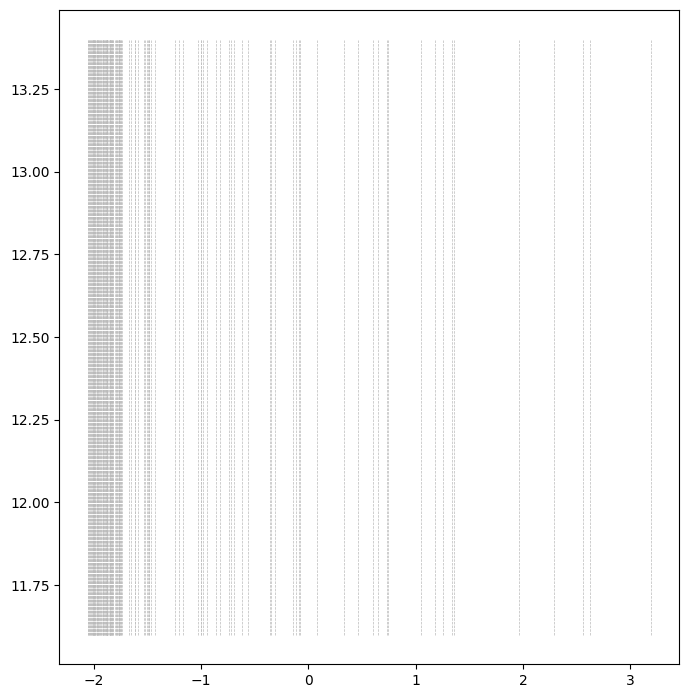

In [51]:
shap.plots.waterfall(shap_vals_waterfall[0], max_display=14)

In [47]:
shap.plots.waterfall(shap_values_16_p_5, max_display=14)

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

steps for model 17: compute shap values on 50 samples per cell type

In [18]:
X_train_p = pd.read_pickle('private_X_train_svd_64.pkl')
X_train_p = X_train_p.iloc[np.sort(X_train_p_sampled.obs['ID'])]

X_test_p = ad.read_h5ad('private_test_input_64_svd_50_samples.h5ad')

print('X_train: ', X_train_p.shape)
print('X_test: ', X_test_p.shape)

# med = X_train_p.median().values.reshape((1,X_train_p.shape[1]))
# explainer17_p = shap.KernelExplainer(model17, med)

# shap_values_17_p = explainer17_p.shap_values(X_test_p.to_df(), nsamples=300)

X_train:  (1120, 148)
X_test:  (350, 148)


  0%|          | 0/350 [00:00<?, ?it/s]

In [19]:
# np.save('shap_values_17_50_samples_p_ct_distr.npy', np.array(shap_values_17_p, dtype=object), allow_pickle=True)